In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase import Atoms
from ase.build import bulk
from ase.build import make_supercell
from numpy import poly1d
from numpy import polyfit
import tensorflow as tf
import tensorflow_probability as tfp
import time
import sys
sys.path.append('../code')
from Generate_Descriptors import get_dscribe_descriptors


In [4]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [5]:
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

In [6]:
class discrete_dscribe_variable():
    def __init__(self, variable_name, default_value, value_array, profiler_to_soap_map = lambda x: x):
        self.name = variable_name
        self.profiler_to_soap_map = profiler_to_soap_map 
        self.default_profiler_value = default_value
        self.default_soap_value = self.profiler_to_soap_map(self.default_profiler_value)
        self.profiler_value_array = value_array
        self.soap_value_array = [self.profiler_to_soap_map(profiler_value) for profiler_value in self.profiler_value_array]
        self.refresh()
        self.times = []
        
    def refresh(self):
        self.current_profiler_value = self.default_profiler_value
        self.current_soap_value = self.profiler_to_soap_map(self.current_profiler_value)
        
    def plot(self, title="", max_time = 0):
        self.fig, self.ax = plt.subplots()
        self.ax.plot(self.soap_value_array, self.times, "o", c='k',zorder=1)
        self.best_fit_coefficients = polyfit(self.soap_value_array, self.times, 2)
        self.best_fit_equation = "t =  {:.1f} x^2 \n+ {:.0f} x \n+ {:.0f}".format(*self.best_fit_coefficients)
        self.equation_y_position = max(min(self.times[len(self.times)//2]/max_time + .2, .9), .2)
        self.polynomial_fit = poly1d(self.best_fit_coefficients)
        self.ax.plot(self.soap_value_array, self.polynomial_fit(self.soap_value_array), '--', c='r', zorder=0)
        self.ax.text(0.5, self.equation_y_position, self.best_fit_equation, horizontalalignment='center', verticalalignment='center', transform=self.ax.transAxes)
        self.ax.set_title(title)
        self.ax.set_xlabel(self.name)
        self.ax.set_ylabel("Time per structure (ms)")
        self.ax.set_ylim(0,1.1*max_time)
        
        
class dscribe_profiler():
    def __init__(self, structure_list, name=""):
        if isinstance(structure_list, Atoms):
            self.structures = [structure_list]
        elif isinstance(structure_list, (list,np.ndarray)):
            self.structures = structure_list
        self.n_structures = len(self.structures)
        self.n_atoms = len(self.structures[-1].positions)
        self.species = np.unique(self.structures[0].get_chemical_symbols())
        self.unique_elements_count = len(self.species)
        self.name = name if name else self.structures[0].get_chemical_formula()
        self.max_time = 0
        
        self.variables = {}
        self.lmaxs = self.add_dscribe_variable("lmax", 9, range(0,10))
        self.nmaxs = self.add_dscribe_variable("nmax", 11, range(1,12))
        self.element_options = ["C", "H", "O", "N", "He", "Li", "Be", "B", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar"]
        #self.element_counts = self.add_dscribe_variable("element_count", self.unique_elements_count, range(self.unique_elements_count, 10))
        self.element_counts = self.add_dscribe_variable("element_count", 9, range(self.unique_elements_count, 10))
        # it turns out you need rcuts to be floats not ints or a numerical issue appears (hence the 1.0)
        self.rcuts = self.add_dscribe_variable("rcut", 14, np.arange(2, 15, 1.0)) 
        
        self.format="default"
    
    def vary_by_structure_mode(self):
        self.format="vary_by_structure"
        self.structure_ids = self.add_dscribe_variable("atom_count", -1, range(len(self.structures)), lambda x: len(self.structures[x].positions))
        self.n_structures = 1
        self.max_time = 0
        
    def get_structures(self):
        if self.format == "default":
            return self.structures
        elif self.format == "vary_by_structure":
            return self.structures[self.structure_ids.current_profiler_value]
        
        
    def add_dscribe_variable(self, variable_name, default_value, value_array, profiler_to_soap_map = lambda x: x):
        self.variables[variable_name] = discrete_dscribe_variable(variable_name, default_value, value_array,profiler_to_soap_map)
        return self.variables[variable_name]
           
    def time_SOAP(self):
        SoapList, SoapTime = TickTock(get_dscribe_descriptors, is_global=False, return_derivatives = False, rbf_type='polynomial', is_periodic=False,
                                      atoms_list=self.get_structures(),
                                      species = self.element_options[:self.element_counts.current_profiler_value],
                                      rcut = self.rcuts.current_profiler_value,
                                      nmax = self.nmaxs.current_profiler_value,
                                      lmax = self.lmaxs.current_profiler_value)
        return SoapTime

    
    def collect_time_by_variable(self, test_variable, initial_runs=10):
        for variable_name, variable in self.variables.items():
            variable.refresh()
            
        for i in range(initial_runs):
            self.time_SOAP()
        
        test_variable_range = self.variables[test_variable].profiler_value_array
        self.variables[test_variable].times = []
        for test_value in test_variable_range:
            self.variables[test_variable].current_profiler_value = test_value
            test_time = self.time_SOAP()/self.n_structures*1000
            self.max_time = max(self.max_time, test_time)
            self.variables[test_variable].times.append(test_time)
            # print(test_value, test_time)
            
    def collect_all_times(self, initial_runs=10):
        for variable_name, variable in self.variables.items():
            self.collect_time_by_variable(variable_name, initial_runs=initial_runs)
            print("Finished collecting {}".format(variable_name))
    
    def plot_time_by_variable(self, test_variable):
        constant_atom_count_string = "" if (self.format == "vary_by_structure") else " (which has {} atoms)".format(self.n_atoms)
        title="Soap times for {}{} with varying {}\n".format(self.name, constant_atom_count_string, test_variable)
        for variable_name, variable in self.variables.items():
            if variable_name != test_variable:
                title += "{} = {}, ".format(variable_name, variable.default_soap_value)
        return self.variables[test_variable].plot(title, self.max_time)
    
    def plot_all_times(self):
        for variable_name, variable in self.variables.items():
            self.plot_time_by_variable(variable_name)


Finished collecting lmax
Finished collecting nmax
Finished collecting element_count
Finished collecting rcut


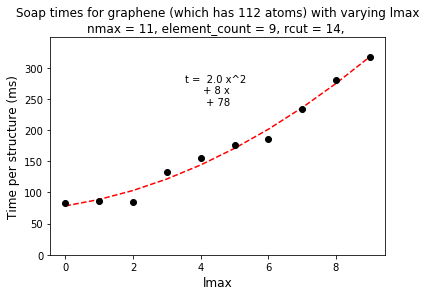

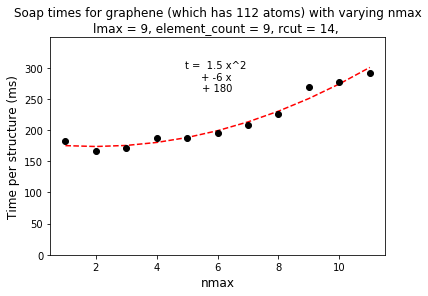

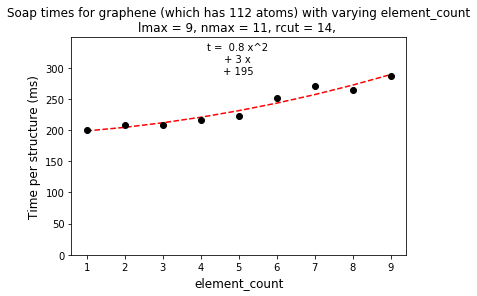

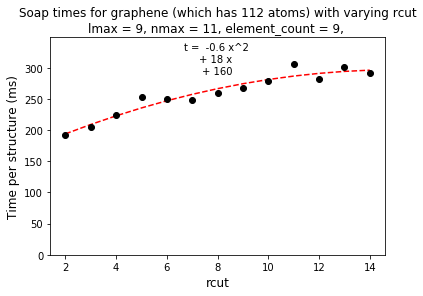

In [8]:
graphene = read("../data/ManyGraphenes.gz",":10")
graphene_profiler = dscribe_profiler(graphene, "graphene")
graphene_profiler.collect_all_times(initial_runs=0)
graphene_profiler.plot_all_times()

Finished collecting lmax
Finished collecting nmax
Finished collecting element_count
Finished collecting rcut


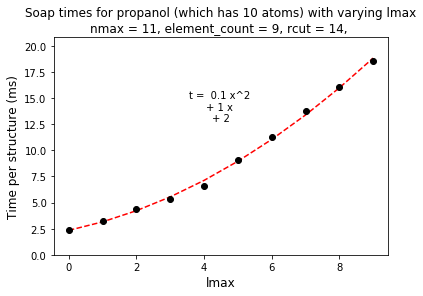

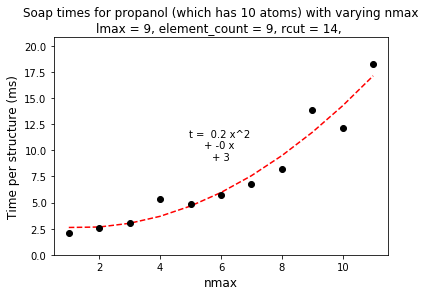

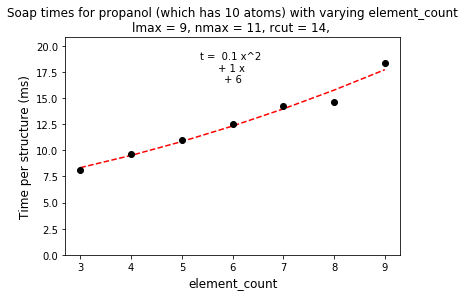

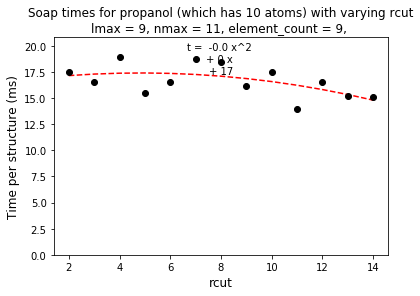

In [6]:
propanol = read("../data/distorted_propanol.extxyz.gz",":100")
propanol_profiler = dscribe_profiler(propanol, "propanol")
propanol_profiler.collect_all_times(initial_runs=0)
propanol_profiler.plot_all_times()

Finished collecting lmax
Finished collecting nmax
Finished collecting element_count
Finished collecting rcut
Finished collecting atom_count


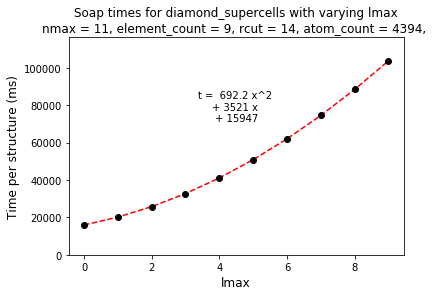

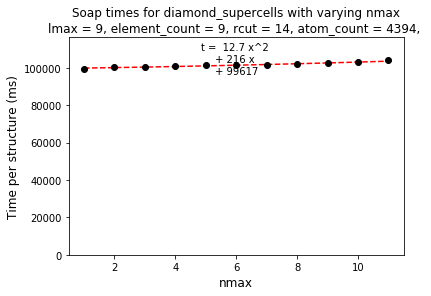

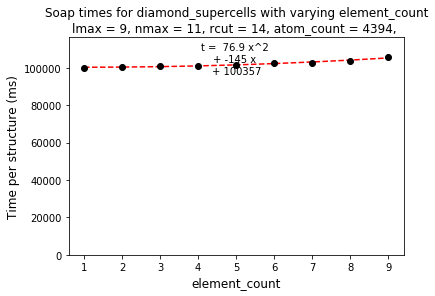

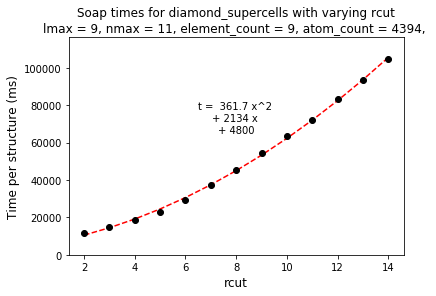

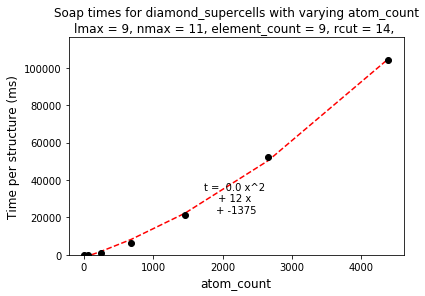

In [17]:

diamond = bulk("C", 'diamond')
diamond_supercells = []
for i in range(1,15,2):
    diamond_supercells.append(make_supercell(diamond, np.identity(3)*i))
diamond_supercells_profiler = dscribe_profiler(diamond_supercells, "diamond_supercells")
diamond_supercells_profiler.vary_by_structure_mode()
diamond_supercells_profiler.collect_all_times(initial_runs=0)
diamond_supercells_profiler.plot_all_times()


In [7]:
from ase.build import bulk
BN = bulk("BN", crystalstructure='wurtzite', a=2.504)
from Visualize_Structures import Structure3DPlot, Structure3DAnimation
Structure3DAnimation([BN], rotate=True, rotation_rates={'elev':0, 'azim':3}).Plot()

{'rotate': True, 'rotation_rates': {'elev': 0, 'azim': 3}}
Generating animation frame 0 (0% complete)
Generating animation frame 10 (10% complete)
Generating animation frame 20 (20% complete)
Generating animation frame 30 (30% complete)
Generating animation frame 40 (40% complete)
Generating animation frame 50 (50% complete)
Generating animation frame 60 (60% complete)
Generating animation frame 70 (70% complete)
Generating animation frame 80 (80% complete)
Generating animation frame 90 (90% complete)
Generating animation frame 100 (100% complete)


Finished collecting lmax
Finished collecting nmax
Finished collecting element_count
Finished collecting rcut


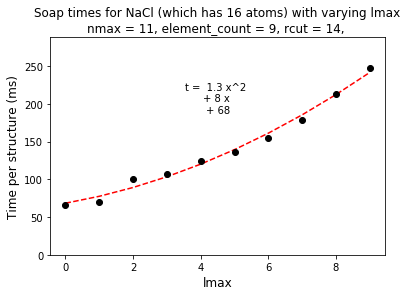

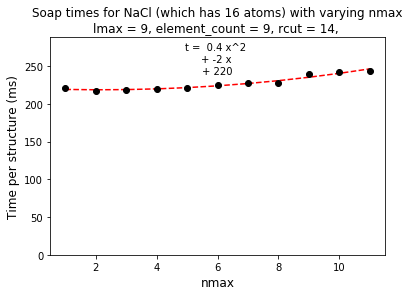

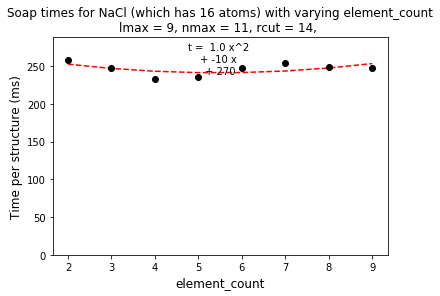

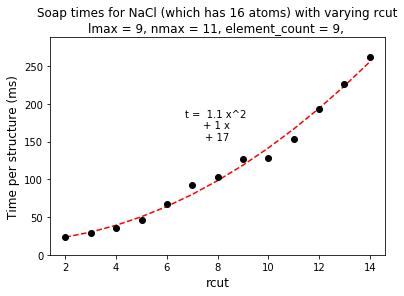

In [9]:
from ase.build import bulk
NaCl = bulk("NaCl", crystalstructure='rocksalt', a=5.6413)
NaCl=make_supercell(NaCl, np.identity(3)*2)
NaCl_profiler = dscribe_profiler(NaCl, "NaCl")
NaCl_profiler.collect_all_times(initial_runs=10)
NaCl_profiler.plot_all_times()

Finished collecting lmax
Finished collecting nmax
Finished collecting element_count
Finished collecting rcut


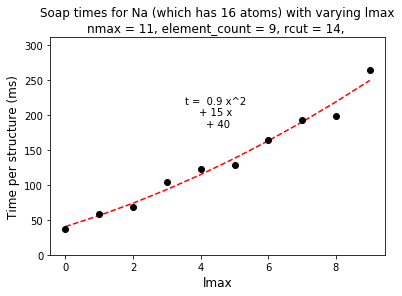

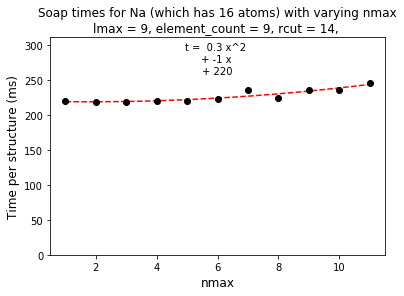

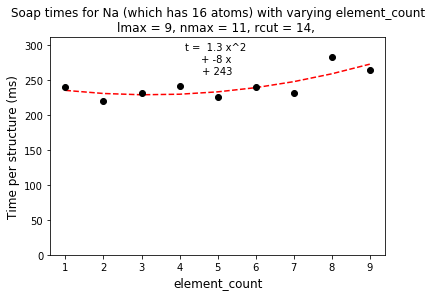

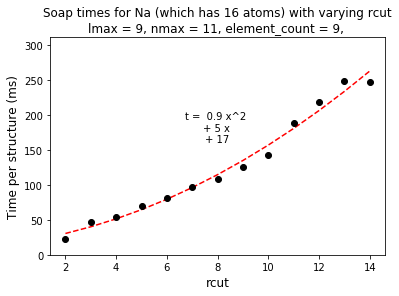

In [10]:
from ase.build import bulk
Na = bulk("NaNa", crystalstructure='rocksalt', a=5.6413)
Na = make_supercell(Na, np.identity(3)*2)
Na_profiler = dscribe_profiler(Na, "Na")
Na_profiler.collect_all_times(initial_runs=10)
Na_profiler.plot_all_times()

In [8]:
from ase.build import bulk
diamond = bulk("C", crystalstructure='diamond')
from Visualize_Structures import Structure3DPlot, Structure3DAnimation
Structure3DAnimation([diamond], rotate=True, rotation_rates={'elev':0, 'azim':3}).Plot()

{'rotate': True, 'rotation_rates': {'elev': 0, 'azim': 3}}
Generating animation frame 0 (0% complete)
Generating animation frame 10 (10% complete)
Generating animation frame 20 (20% complete)
Generating animation frame 30 (30% complete)
Generating animation frame 40 (40% complete)
Generating animation frame 50 (50% complete)
Generating animation frame 60 (60% complete)
Generating animation frame 70 (70% complete)
Generating animation frame 80 (80% complete)
Generating animation frame 90 (90% complete)
Generating animation frame 100 (100% complete)


Looking at the dot product scaling

In [5]:
def time_dot_product_matrix(n_structs, method="numpy"):
    graphenes = read("../data/ManyGraphenes.gz", ":{}".format(n_structs))
    n_atoms = len(graphenes[0].positions)
    print("Timing dot product matrix generation with {} method for {} structures for a total of {} individual local descriptors  ".format(method, n_structs, n_structs*n_atoms))
    (DotProductMatrix, SoapTime), TotalTime = TickTock(genrate_dot_product_matrix, graphenes, method)
    DotProductTime = TotalTime - SoapTime
    print("Took {:.2f} seconds to generate dot product matrix from soap descriptors".format(DotProductTime))

In [14]:
def genrate_dot_product_matrix(structure, method="numpy"):
    SoapList, SoapTime = TickTock(get_dscribe_descriptors, is_global=False, return_derivatives = False, rbf_type='gto', is_periodic=True,
                                      atoms_list=structure,
                                      species = ["C"],
                                      rcut = 14,
                                      nmax = 11,
                                      lmax = 9)
    n_structs = len(structure)
    n_atoms = len(structure[0].positions)
    print("Took {:.2f} seconds to generate descriptors".format(SoapTime))
    if method == "numpy":
        SoapList = SoapList.astype('float64')
        SoapList_separated = SoapList.reshape([-1, SoapList.shape[-1]])
        dot_product_matrix = np.matmul(SoapList_separated, SoapList_separated.T)
    elif method == "tensorflow":
        SoapTensor = tf.constant(SoapList, dtype=tf.float32)
        SoapTensor = tf.reshape(SoapTensor, [-1, SoapList.shape[-1]])
        my_exp = tf.constant(1, dtype=tf.float32)
        polynomial_kernel = tfp.math.psd_kernels.Polynomial(exponent=my_exp)
        dot_product_matrix = polynomial_kernel.matrix(SoapTensor, SoapTensor)
    return dot_product_matrix, SoapTime

In [65]:
time_dot_product_matrix(1)

Timing dot product matrix generation for 1 structures for a total of 112 individual local descriptors  
Took 0.35 seconds to generate descriptors
Took 0.01 seconds to generate dot product matrix from soap descriptors


In [66]:
time_dot_product_matrix(2)

Timing dot product matrix generation for 2 structures for a total of 224 individual local descriptors  
Took 0.61 seconds to generate descriptors
Took 0.01 seconds to generate dot product matrix from soap descriptors


In [38]:
b = time_dot_product_matrix(10)

Timing dot product matrix generation for 10 structures for a total of 1120 individual local descriptors  
Took 2.61 seconds to generate descriptors
Took 0.06 seconds to generate dot product matrix from soap descriptors


In [68]:
time_dot_product_matrix(100)

Timing dot product matrix generation for 100 structures for a total of 11200 individual local descriptors  
Took 24.31 seconds to generate descriptors
Took 1.16 seconds to generate dot product matrix from soap descriptors


In [69]:
time_dot_product_matrix(300)

Timing dot product matrix generation for 300 structures for a total of 33600 individual local descriptors  
Took 72.56 seconds to generate descriptors
Took 13.18 seconds to generate dot product matrix from soap descriptors


In [70]:
time_dot_product_matrix(1000)

Timing dot product matrix generation for 1000 structures for a total of 112000 individual local descriptors  
Took 244.00 seconds to generate descriptors
Took 361.66 seconds to generate dot product matrix from soap descriptors


In [71]:
time_dot_product_matrix(2000)

Timing dot product matrix generation for 2000 structures for a total of 224000 individual local descriptors  
Took 487.77 seconds to generate descriptors


MemoryError: Unable to allocate 187. GiB for an array with shape (224000, 224000) and data type float32

In [17]:
time_dot_product_matrix(1, method="tensorflow")

Timing dot product matrix generation with tensorflow method for 1 structures for a total of 112 individual local descriptors  
Took 0.32 seconds to generate descriptors
Took 0.01 seconds to generate dot product matrix from soap descriptors


In [18]:
time_dot_product_matrix(2, method="tensorflow")

Timing dot product matrix generation with tensorflow method for 2 structures for a total of 224 individual local descriptors  
Took 0.58 seconds to generate descriptors
Took 0.04 seconds to generate dot product matrix from soap descriptors


In [19]:
time_dot_product_matrix(10, method="tensorflow")

Timing dot product matrix generation with tensorflow method for 10 structures for a total of 1120 individual local descriptors  
Took 2.56 seconds to generate descriptors
Took 0.49 seconds to generate dot product matrix from soap descriptors


In [20]:
time_dot_product_matrix(100, method="tensorflow")

Timing dot product matrix generation with tensorflow method for 100 structures for a total of 11200 individual local descriptors  
Took 24.29 seconds to generate descriptors


ResourceExhaustedError: OOM when allocating tensor with shape[11200,11200,660] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [ ]:
time_dot_product_matrix(300, method="tensorflow")

In [ ]:
time_dot_product_matrix(1000, method="tensorflow")

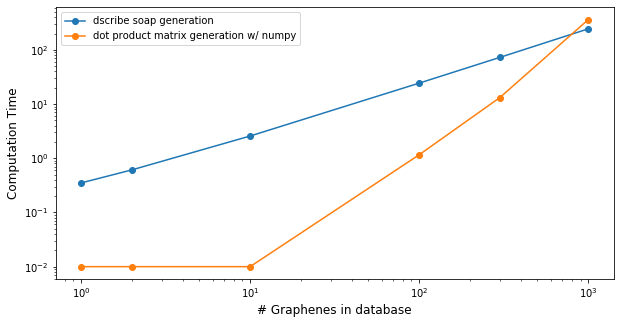

In [23]:
n_structs = [1,2,10,100,300,1000]
soap_times = [.35, .61, 2.57, 24.31, 72.56, 244.00]
dot_product_times_numpy = [.01, .01, .01, 1.16, 13.18, 361.66]
#dot_product_times_tf = [.02, .06, .89,

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(n_structs, soap_times, "-o", label="dscribe soap generation")
ax.plot(n_structs, dot_product_times_numpy, "-o", label="dot product matrix generation w/ numpy")
#plt.plot(n_structs, dot_product_times_tf, "-o", label="dot product matrix generation w/ tensorflow")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("# Graphenes in database")
ax.set_ylabel("Computation Time")
ax.set_title("")
ax.legend()
plt.savefig('../media/descriptor_generation_vs_dot_product_calculation.png')

Added the following to profile forces as well

In [9]:
FullStructureList = read("../data/distorted_propanol.extxyz.gz", ":")#, ":{}".format(my_n))

In [39]:
# I only use these settings if I am training on diatomic structures
# ------------------------------------------------------------------------
use_diatomics = False
if use_diatomics:
    my_element = "O"
    my_temp=300
    my_calc = "EMT"
    my_md_seed = 1

# Number of structures    
# ------------------------------------------------------------------------
my_n = 800

# SOAP parameters
# ------------------------------------------------------------------------
get_local_descriptors = True
my_rcut = 5
my_nmax = 8
my_lmax = 8
attach_SOAP_center = True
is_periodic = False
use_forces =True

StructureList = FullStructureList[::2000//my_n][:my_n]


In [46]:
def for_profiling(use_forces=False):
    dscribe_output = get_dscribe_descriptors(
                                            StructureList,
                                            species=np.unique(StructureList[0].get_chemical_symbols()), 
                                            attach=attach_SOAP_center, 
                                            is_periodic = is_periodic,
                                            is_global= not get_local_descriptors,
                                            return_derivatives= use_forces, 
                                            nmax=my_nmax, 
                                            lmax=my_lmax,
                                            rcut=my_rcut
                                            )
    

In [49]:
import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()

for_profiling()


profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

         200994 function calls (196149 primitive calls) in 1.137 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.136    0.568 /home/sstafford/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3288(run_code)
        2    0.000    0.000    1.136    0.568 {built-in method builtins.exec}
        1    0.005    0.005    1.136    1.136 <ipython-input-49-de543daf5d1d>:6(<module>)
        1    0.000    0.000    1.132    1.132 <ipython-input-46-91725d6ad894>:1(for_profiling)
        1    0.000    0.000    1.131    1.131 ../code/Generate_Descriptors.py:7(get_dscribe_descriptors)
        1    0.006    0.006    1.122    1.122 /home/sstafford/anaconda3/lib/python3.7/site-packages/dscribe/descriptors/soap.py:391(create)
        1    0.000    0.000    1.111    1.111 /home/sstafford/anaconda3/lib/python3.7/site-packages/dscribe/descriptors/descriptor.py:164(create_parallel)
        1  

In [47]:
%reload_ext snakeviz
%snakeviz for_profiling(use_forces = False)

 
*** Profile stats marshalled to file '/tmp/tmpwagfl3r6'. 
Embedding SnakeViz in this document...


In [48]:
%reload_ext snakeviz
%snakeviz for_profiling(use_forces = True)

 
*** Profile stats marshalled to file '/tmp/tmpkv_83y6o'. 
Embedding SnakeViz in this document...
